In [1]:
import seaborn as sns

In [ ]:
import time
import numpy as np
import torch
import torch.nn as nn
import math
from scipy.linalg import lstsq,pinv
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
torch.set_default_dtype(torch.float64)

def set_seed(x):
    np.random.seed(x)
    torch.manual_seed(x)
    torch.cuda.manual_seed_all(x)
    torch.backends.cudnn.deterministic = True

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.uniform_(m.weight, a = -R_m, b = R_m) #第一层到第二层的随机固定权值
        nn.init.uniform_(m.bias, a = -R_m, b = R_m) #偏置元的随即固定权值



class local_rep(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers, M, x_max, x_min, y_max, y_min):
        super(local_rep, self).__init__()
        self.in_features = in_features #输入元的维度
        self.out_features = out_features #输出元的维度 2
        self.hidden_features = M #基函数的个数 隐藏层的个数
        self.hidden_layers  = hidden_layers #隐藏层的层数
        self.M = M
        self.a = torch.tensor([2.0/(x_max - x_min),2.0/(y_max - y_min)]) #每个单元半径的倒数
        self.x_0 = torch.tensor([(x_max + x_min)/2,(y_max + y_min)/2]) #每个单元的中心点
        self.hidden_layer = nn.Sequential(nn.Linear(self.in_features, self.hidden_features, bias=True),nn.Tanh())
        #print([x_min,x_max],[y_min,y_max])

    def forward(self,x):
        x = self.a * (x - self.x_0) #标准化
        x = self.hidden_layer(x)
        return x
    
L_x=1.5 #0-1.5
L_y=1.5 #0-1.5
Nb=1 #time-block

def anal_u(x,y):
    u=(2.5*np.sin(np.pi*x-2*np.pi/5)+1.5*np.cos(2*np.pi*x+3*np.pi/10))*\
       (2.5*np.sin(np.pi*y-2*np.pi/5) + 1.5*np.cos(2*np.pi*y+3*np.pi/10))
    return u

def anal_r(x,y): #真实R
    r=100*(1+0.25*np.sin(2*np.pi*x)+0.25*np.sin(2*np.pi*y))
    return r

def anal_u_x(x,y):
    u = (2.5*np.pi*np.cos(np.pi*x-2*np.pi/5)-3*np.pi*np.sin(2*np.pi*x+3*np.pi/10))*\
       (2.5*np.sin(np.pi*y-2*np.pi/5) + 1.5*np.cos(2*np.pi*y+3*np.pi/10))
    return u

def anal_u_y(x,y):
    return anal_u_x(y,x)

def anal_u_xx(x,y):
    u=(-2.5*np.pi**2*np.sin(np.pi*x-2*np.pi/5)-6*np.pi**2*np.cos(2*np.pi*x+3*np.pi/10))*\
       (2.5*np.sin(np.pi*y-2*np.pi/5) + 1.5*np.cos(2*np.pi*y+3*np.pi/10))
    return u

def anal_u_yy(x,y):
    return anal_u_xx(y,x)

def anal_f(x,y): # f(x,y) = u_xx + u_yy - r*u
    f = anal_u_xx(x,y) + anal_u_yy(x,y) + anal_r(x,y)*anal_u(x,y)
    return f

vanal_r=np.vectorize(anal_r)
vanal_u=np.vectorize(anal_u)
vanal_f=np.vectorize(anal_f)

def pre_define(Nx,Ny,M,Qx,Qy): #Nx为x方向单元数 Ny为y方向单元数 M为基函数个数 Qx为单元x方向的单元 Qy为y方向配点个数 
    models = []
    points = []
    for k in range(Nx): #遍历x方向的单元数
        model_for_x = []
        point_for_x = []
        #mea_points=[]
        x_min = L_x/Nx * k #L/Nx为单元直径 
        x_max = L_x/Nx * (k+1)
        x_devide = np.linspace(x_min, x_max, Qx + 1)
        for n in range(Ny):
            y_min = L_y/Ny * n
            y_max = L_y/Ny * (n+1)
            model = local_rep(in_features = 2, out_features = 2, hidden_layers = 1, M = M, x_min = x_min, 
                              x_max = x_max, y_min = y_min, y_max = y_max)
            model = model.apply(weights_init)
            model = model.double()
            for param in model.parameters():
                param.requires_grad = False
            # for name,value in model.named_parameters(): #√ 和copy2相同
            #     print('R_m:',name,value)
            model_for_x.append(model)
            y_devide = np.linspace(y_min, y_max, Qy + 1)
            grid = np.array(list(itertools.product(x_devide,y_devide))).reshape(Qx+1,Qy+1,2) #存放一个单元中的配点 Qx+1个矩阵，Qy+1行 2个列(x,t)
            point_for_x.append(torch.tensor(grid,requires_grad=True)) #储存第k列所有单元的配点
        models.append(model_for_x)
        points.append(point_for_x) #[:,:,0]为x方向配点 [:,:,1]为t方向配点 product形式
        #points 第1维代表第几列单元 第2维代表单元中
    return(models,points)

#Nx,Ny x,y方向单元数，Qx,Qy x,y方向配点数 
#别忘了还有测量误差！ 先选取和采样点一样的测量点
def residual_vector(models,points,Nx,Ny,M,Qx,Qy):
 #Qx，Qy是每个局部区域的单元数
    u=np.zeros([Nx*Ny*(Qx+1)*(Qy+1),Nx*Ny*M]) #基函数 u,r
    u_xx=np.zeros([Nx*Ny*(Qx+1)*(Qy+1),Nx*Ny*M]) #基函数关于x的二阶导
    u_yy=np.zeros([Nx*Ny*(Qx+1)*(Qy+1),Nx*Ny*M]) #基函数关于y的二阶导
    f=np.zeros([Nx*Ny*(Qx+1)*(Qy+1),1]) #方程误差+边界误差+单元连续误差

    g1 = np.zeros([Ny*(Qy+1),Nx*Ny*M]) # u(a1,y) 少了最后一个关于t的
    g1_value = np.zeros([Ny*(Qy+1),1]) # g1(y)

    g2 = np.zeros([Ny*(Qy+1),Nx*Ny*M]) # u(b1,y)
    g2_value = np.zeros([Ny*(Qy+1),1]) # g2(y)

    g3 = np.zeros([Nx*(Qx+1),Nx*Ny*M]) # u(x,a2)
    g3_value = np.zeros([Nx*(Qx+1),1]) # g3(x)

    g4 = np.zeros([Nx*(Qx+1),Nx*Ny*M]) # u(x,b2)
    g4_value = np.zeros([Nx*(Qx+1),1]) # g4(x)
    
    A_x_c=np.zeros([Ny*(Qy+1)*(Nx-1),Nx*Ny*M]) #x方向 C0连续
    f_x_c=np.zeros([Ny*(Qy+1)*(Nx-1),1])

    A_x_c_1=np.zeros([Ny*(Qy+1)*(Nx-1),Nx*Ny*M]) #x方向 C1连续
    f_x_c_1=np.zeros([Ny*(Qy+1)*(Nx-1),1])

    A_y_c=np.zeros([Nx*(Qx+1)*(Ny-1),Nx*Ny*M]) #y方向 C0连续
    f_y_c=np.zeros([Nx*(Qx+1)*(Ny-1),1])

    A_y_c_1=np.zeros([Nx*(Qx+1)*(Ny-1),Nx*Ny*M]) #y方向 C1连续
    f_y_c_1=np.zeros([Nx*(Qx+1)*(Ny-1),1])

    k=0
    n=0
    r=[] #r(x,y)

    for k in range(Nx):
        for n in range(Ny):
            in_=points[k][n].detach().numpy() #第k列第n行单元的配点(Qx+1,Qy+1,2) 3维的
            out=models[k][n](points[k][n]) #(Qx+1,Qy+1,M) #最后一列代表基函数
            values=out.detach().numpy() #第3个维度表示基函数
            M_begin=(k*Ny+n)*M #基函数的开始
            grads=[]
            grads_2_xx=[]
            grads_2_yy=[]
            for i in range(M):
                g_1 = torch.autograd.grad(outputs=out[:,:,i], inputs=points[k][n], #[:,:,i]为2维向量
                            grad_outputs=torch.ones_like(out[:,:,i]),
                            create_graph = True, retain_graph = True)[0]
                grads.append(g_1.squeeze().detach().numpy()) #(M,Qx+1,Qy+1,2)
                g_2_x=torch.autograd.grad(outputs=g_1[:,:,0], inputs=points[k][n], #x的2阶导
                            grad_outputs=torch.ones_like(out[:,:,i]),
                            create_graph = True, retain_graph = True)[0]
                g_2_y=torch.autograd.grad(outputs=g_1[:,:,1], inputs=points[k][n], #y的2阶导
                        grad_outputs=torch.ones_like(out[:,:,i]),
                        create_graph = True, retain_graph = True)[0]

                grads_2_xx.append(g_2_x[:,:,0].squeeze().detach().numpy()) #(M,Qx+1,Qy+1)
                grads_2_yy.append(g_2_y[:,:,1].squeeze().detach().numpy()) ##! (M,Qx+1,Qy+1)

            grads = np.array(grads).swapaxes(0,3) #第一个维度与第4个维度交换 (M,Qx+1,Qy+1,2)->(2,Qx+1,Qy+1,M) 第1维度：关于x或t求导 2：x 3:y 4:基函数个数
            grads_2_xx = np.array(grads_2_xx).transpose(1,2,0).reshape(-1,M) #行对应左下配点，列对应基函数的个数(Qx*Qy,M) 样本的顺序为：先固定x，让y变化
            grads_2_yy = np.array(grads_2_yy).transpose(1,2,0).reshape(-1,M)

            u[(k*Ny+n)*(Qx+1)*(Qy+1): (k*Ny+n+1)*(Qx+1)*(Qy+1), M_begin : M_begin + M] = values.reshape(-1,M) #1,2维度合并 样本的顺序为：先固定x，让y变化
            u_xx[(k*Ny+n)*(Qx+1)*(Qy+1): (k*Ny+n+1)*(Qx+1)*(Qy+1), M_begin : M_begin + M] = grads_2_xx
            u_yy[(k*Ny+n)*(Qx+1)*(Qy+1): (k*Ny+n+1)*(Qx+1)*(Qy+1), M_begin : M_begin + M] = grads_2_yy

            #mea_points=in_[:Qx,:Qy,:].reshape((-1,2)) #测量点即为采样点 #(20,20,2)->(400,2) 样本顺序 先固定x 让y变化
            f_in = in_.reshape((-1,2)) #(20,20,2)->(400,2) 样本顺序 先固定x 让y变化
            r.append(vanal_r(f_in[:,0],f_in[:,1]).reshape(-1,1))
            
            f[(k*Ny+n)*(Qx+1)*(Qy+1): (k*Ny+n+1)*(Qx+1)*(Qy+1), :] = vanal_f(f_in[:,0],f_in[:,1]).reshape(-1,1) #非齐次项
            #关于残差向量的样本顺序：单元内先自下而上，再自左而右，总的来看也一样 顺序需要和右边f对应

            # u(a1,t) = ..
            if k == 0:
                g1[n*(Qy+1) : (n+1)*(Qy+1), M_begin : M_begin + M] = values[0,:,:]
                g1_value[n*(Qy+1) : (n+1)*(Qy+1),:] =vanal_u(in_[0,:,0],in_[0,:,1]).reshape((Qy+1,1))
            
            #u(b1,y) = 
            if k==Nx-1:
                g2[n*(Qy+1) : (n+1)*(Qy+1), M_begin : M_begin + M] = values[-1,:,:]
                g2_value[n*(Qy+1) : (n+1)*(Qy+1),:] = vanal_u(in_[-1,:,0],in_[-1,:,1]).reshape((Qy+1,1))

            #u(x,a2) =
            if n==0:
                g3[k*(Qx+1):(k+1)*(Qx+1),M_begin:M_begin+M]=values[:,0,:]
                g3_value[k*(Qx+1):(k+1)*(Qx+1),:]=vanal_u(in_[:,0,0],in_[:,0,1]).reshape((Qx+1,1))
            
            #u(x,b2) =
            if n==Ny-1:
                g4[k*(Qx+1):(k+1)*(Qx+1),M_begin:M_begin+M]=values[:,-1,:]
                g4_value[k*(Qx+1):(k+1)*(Qx+1),:]=vanal_u(in_[:,-1,0],in_[:,-1,1]).reshape((Qx+1,1))

            # x_axis continuity
            #关于x连续性的组装 样本的顺序在单元内部是自下而上， 总的来看是先自左而右，再自下而上 没啥影响
            if Nx > 1:
                x_axis_begin = (n*(Nx-1)+k)*(Qy+1) #80 80的跳 先从左到右 再从下向上 
                if k == 0:
                    A_x_c[x_axis_begin : x_axis_begin + Qy+1, M_begin : M_begin + M] = values[-1,:,:] #x方向C0 前面的区域为正
                    A_x_c_1[x_axis_begin : x_axis_begin + Qy+1, M_begin : M_begin + M] = grads[0,-1,:,:] #行为t方向的样本 列为基函数
                elif k == Nx-1:
                    A_x_c[x_axis_begin - (Qy+1) : x_axis_begin, M_begin : M_begin + M] = -values[0,:,:]
                    A_x_c_1[x_axis_begin - (Qy+1) : x_axis_begin, M_begin : M_begin + M] = -grads[0,0,:,:]
                else:
                    A_x_c[x_axis_begin : x_axis_begin + (Qy+1), M_begin : M_begin + M] = values[-1,:,:]
                    A_x_c[x_axis_begin - (Qy+1) : x_axis_begin, M_begin : M_begin + M] = -values[0,:,:]
                    A_x_c_1[x_axis_begin : x_axis_begin + (Qy+1), M_begin : M_begin + M] = grads[0,-1,:,:]
                    A_x_c_1[x_axis_begin - (Qy+1) : x_axis_begin, M_begin : M_begin + M] = -grads[0,0,:,:]

            if Ny > 1:
                y_axis_begin = (k*(Ny-1)+n)*(Qx+1) #先自下向上 再自左向右
                if n == 0:
                    A_y_c[y_axis_begin : y_axis_begin + Qx+1, M_begin : M_begin + M] = values[:,-1,:] #y方向C0 前面的区域为正
                    A_y_c_1[y_axis_begin : y_axis_begin + Qx+1, M_begin : M_begin + M] = grads[1,:,-1,:]
                elif n == Ny-1:
                    A_y_c[y_axis_begin - (Qx+1) : y_axis_begin, M_begin : M_begin + M] = -values[:,0,:] #后面的区域为负
                    A_y_c_1[y_axis_begin - (Qx+1) : y_axis_begin, M_begin : M_begin + M] = -grads[1,:,0,:]
                else:
                    A_y_c[y_axis_begin : y_axis_begin + (Qx+1), M_begin : M_begin + M] = values[:,-1,:]
                    A_y_c[y_axis_begin - (Qx+1) : y_axis_begin, M_begin : M_begin + M] = -values[:,0,:]
                    A_y_c_1[y_axis_begin : y_axis_begin + Qx+1, M_begin : M_begin + M] = grads[1,:,-1,:]
                    A_y_c_1[y_axis_begin - (Qx+1) : y_axis_begin, M_begin : M_begin + M] = -grads[1,:,0,:]
    
    r_true=np.array(r).reshape(-1,1) #测量真实值
    #f=np.concatenate((f,R_mea),axis=0) #所有的残差
    #f为方程对应非齐次项 f_mea为u的真实值 value_and_continue为边界+单元边界估计值 value_and_continue_value为边界+单元边界真实值
    value_and_continue = np.concatenate((g1,g2,g3,g4,A_x_c,A_y_c,A_x_c_1,A_y_c_1),axis=0) #u(a1,y),u(b1,y),u(x,a2),u(x,a3),x y方向C0,x y方向C0,u x方向 C1
    value_and_continue_value = np.concatenate((g1_value,g2_value,g3_value,g4_value,f_x_c,f_y_c,f_x_c_1,f_y_c_1),axis=0)
    return(u,u_xx,u_yy,f,r_true,value_and_continue,value_and_continue_value)
           

def cal_f(w,u,u_xx,u_yy,f,r,value_and_continue,value_and_continue_value):
    part_1 = np.dot(u_xx,w) + np.dot(u_yy,w)+ np.dot(u,w)*r.reshape((-1)) - f.reshape((-1)) #方程残差
    part_2 = np.dot(value_and_continue,w) - value_and_continue_value.reshape((-1)) #边界+连续性残差
    loss=np.concatenate((part_1,part_2),axis=0)
    mat=np.concatenate((u_xx+u_yy+np.diagflat(r)@u,value_and_continue),axis=0)

    return(loss)
            
def cal_j(w,u,u_xx,u_yy,f,r,value_and_continue,value_and_continue_value):
    s=int(0.5*len(w))
    part_1=u_xx+u_yy+r.reshape(-1,1)*u
    part_2=value_and_continue
    return(np.concatenate((part_1,part_2),axis=0))


In [ ]:
"""
@Time ： 2023/10/19 0019 17:11
@Auth ： yeqc
        Jacobi 雅可比迭代法
"""
 
def Jacobi(A, b, max_iter=1000, epsilon=1e-10):
    n = len(b)
    x = np.zeros(n)  # 初始解
    x_new = np.zeros(n)  # 存储更新后的解向量
 
    for iter in range(max_iter):
        for i in range(n):
            sum_ax = np.dot(A[i], x) - A[i][i] * x[i]  # 计算除去对角元素的和
            x_new[i] = (b[i] - sum_ax) / A[i][i]  # 更新解向量的第i个分量
 
        # 判断终止条件
        if np.linalg.norm(x_new - x) < epsilon:
            break
 
        x = np.copy(x_new)  # 更新解向量
    return x


In [4]:
def test(models,Nx,Ny,M,Qx,Qy,w,plot = True):
    epsilon = []
    true_values = []
    numerical_values = []
    test_Qx = 2*Qx #测试点的个数
    test_Qy = 2*Qy
    h = []
    for k in range(Nx):
        epsilon_x = []
        true_value_x = []
        numerical_value_x = []
        for n in range(Ny):
            # forward and grad
            x_min = L_x/Nx * k
            x_max = L_x/Nx * (k+1)
            x_devide = np.linspace(x_min, x_max, test_Qx + 1)[:test_Qx]
            y_min = L_y/Ny * n
            y_max = L_y/Ny * (n+1)
            y_devide = np.linspace(y_min, y_max, test_Qy + 1)[:test_Qy]
            grid = np.array(list(itertools.product(x_devide,y_devide))).reshape(test_Qx,test_Qy,2)
            test_point = torch.tensor(grid,requires_grad=True)
            in_ = test_point.detach().numpy()
            out = models[k][n](test_point)
            values = out.detach().numpy()
            ############ 2-order ############
            true_value = vanal_u(in_[:,:,0],in_[:,:,1])
            numerical_value = np.dot(values, w[k*Ny*M + n*M : k*Ny*M + n*M + M]).reshape(test_Qx,test_Qy) #变换形状 行对应x方向配点 列对应t方向配点
            e = np.abs(true_value - numerical_value)
            true_value_x.append(true_value)
            numerical_value_x.append(numerical_value)
            epsilon_x.append(e)
        
        x_devide_h = torch.tensor(np.linspace(x_min, x_max, Qx + 1)[:Qx]).unsqueeze(dim=1)
        point_h = x_devide_h.repeat((1,2))
        point_h[:,1] = L_y #最后一个t节点的配点
        out = models[k][n](point_h)
        values = out.detach().numpy()
        h.append(np.dot(values, w[k*Ny*M + Ny*M - M : k*Ny*M + Ny*M]).reshape(Qx,1))
        
        
        epsilon_x = np.concatenate(epsilon_x, axis=1) #在第2个维度上拼接数组 横着拼
        epsilon.append(epsilon_x)
        true_value_x = np.concatenate(true_value_x, axis=1)
        true_values.append(true_value_x)
        u_t=np.concatenate(true_values, axis=0).reshape((-1,1))
        numerical_value_x = np.concatenate(numerical_value_x, axis=1)
        numerical_values.append(numerical_value_x)
    h = np.array(h).reshape(Nx*Qx)
    epsilon = np.concatenate(epsilon, axis=0)
    true_values = np.concatenate(true_values, axis=0)
    numerical_values = np.concatenate(numerical_values, axis=0)
    e = epsilon.reshape((-1,1))
    print('********************* ERROR *********************')
    print('Nx=%s,Ny=%s,M=%s,Qx=%s,Qy=%s'%(Nx,Ny,M,Qx,Qy))
    u_o=math.sqrt(sum(u_t*u_t)/len(true_values.reshape((-1,1))))
    print('u_L_inf=',e.max(),'u_l_inf=',e.max()/u_o,'u_L_2=',math.sqrt(sum(e*e)/len(e)),'u_l_2=',math.sqrt(sum(e*e)/len(e))/u_o)# *为矩阵逐元素乘法
    print("边值条件误差")
    print(max(epsilon[0,:]),max(epsilon[-1,:]),max(epsilon[:,0]),max(epsilon[:,-1]))
    print('********************* ERROR *********************')
    if plot == True:
        sns.heatmap(epsilon.T, cmap="YlGnBu").invert_yaxis() #反转 y 轴的方向

    return(e.max(),math.sqrt(sum(e*e)/len(e)),h)

def main(Nx,Ny,M,Qx,Qy,method,moore = False):

    models,points = pre_define(Nx,Ny,M,Qx,Qy)
    
    # matrix define (Aw=b)
    u,u_xx,u_yy,f,r,value_and_continue,value_and_continue_value = residual_vector(models,points,Nx,Ny,M,Qx,Qy)
    #print(u,u_xx,u_yy,f,r,value_and_continue,value_and_continue_value)
    mat=np.concatenate((u_xx+u_yy+np.diagflat(r)@u,value_and_continue),axis=0)
    F=np.concatenate((f,value_and_continue_value),axis=0)
    #print(mat)
    print('正问题的矩阵的条件数：',np.linalg.cond(mat))
    print("矩阵的行列数:","(%d,%d)"%(mat.shape[0],mat.shape[1]))

    if method==1:
        if moore:
            inv_coeff_mat_m=pinv(mat) 
            w=np.matmul(inv_coeff_mat_m,F)
        else:
            w=lstsq(mat,F)[0]
    else:
        w=Jacobi(mat,F)

    return(test(models,Nx,Ny,M,Qx,Qy,w))


正问题的矩阵的条件数： 3.2546772264592584e+18
矩阵的行列数: (480,400)
********************* ERROR *********************
Nx=1,Ny=1,M=400,Qx=19,Qy=19
u_L_inf= 0.003323942302602134 u_l_inf= 0.0006474238107551852 u_L_2= 0.0012526826437799863 u_l_2= 0.0002439923732334397
边值条件误差
0.0029895249824885006 0.0014707802603646236 0.0031839261619683867 0.0028948001514188526
********************* ERROR *********************
程序运行时间： 1.636047124862671


C:\Users\78531\AppData\Local\Temp\ipykernel_92488\2987859532.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_o=math.sqrt(sum(u_t*u_t)/len(true_values.reshape((-1,1))))
C:\Users\78531\AppData\Local\Temp\ipykernel_92488\2987859532.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('u_L_inf=',e.max(),'u_l_inf=',e.max()/u_o,'u_L_2=',math.sqrt(sum(e*e)/len(e)),'u_l_2=',math.sqrt(sum(e*e)/len(e))/u_o)# *为矩阵逐元素乘法
C:\Users\78531\AppData\Local\Temp\ipykernel_92488\2987859532.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from yo

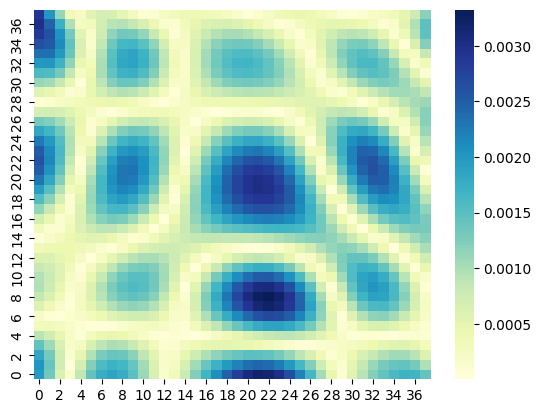

In [5]:
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
if __name__ == '__main__':
    #set_seed(100)
    Nx = 1 # the number of sub-domains 
    Ny = 1
    M = 400 # the number of training parameters per sub-domain
    Qx = 19 # the number of collocation pointss per sub-domain 
    Qy = 19
    R_m=0.5
    time_start = time.time()  # 记录开始时间
    a = main(Nx,Ny,M,Qx,Qy,1,True)
    time_end = time.time()  # 记录结束时间
    print('程序运行时间：',time_end-time_start)
    

正问题的矩阵的条件数： 8.536387272911037e+17
矩阵的行列数: (1760,400)
********************* ERROR *********************
Nx=1,Ny=1,M=400,Qx=39,Qy=39
u_L_inf= 0.005981333575812542 u_l_inf= 0.0011640157961550436 u_L_2= 0.0022151329270321705 u_l_2= 0.00043108274851538125
边值条件误差
0.005581279778244408 0.0053101786016336305 0.005581279778244408 0.0053926125690941795
********************* ERROR *********************
程序运行时间： 2.5617222785949707


C:\Users\78531\AppData\Local\Temp\ipykernel_92488\2987859532.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_o=math.sqrt(sum(u_t*u_t)/len(true_values.reshape((-1,1))))
C:\Users\78531\AppData\Local\Temp\ipykernel_92488\2987859532.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('u_L_inf=',e.max(),'u_l_inf=',e.max()/u_o,'u_L_2=',math.sqrt(sum(e*e)/len(e)),'u_l_2=',math.sqrt(sum(e*e)/len(e))/u_o)# *为矩阵逐元素乘法
C:\Users\78531\AppData\Local\Temp\ipykernel_92488\2987859532.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from yo

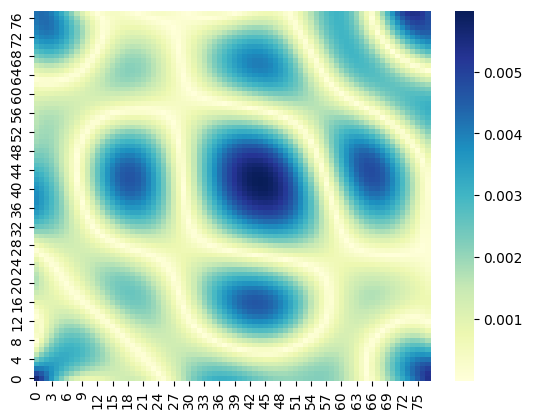

In [6]:
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
if __name__ == '__main__':
    #set_seed(100)
    Nx = 1 # the number of sub-domains 
    Ny = 1
    M = 400 # the number of training parameters per sub-domain
    Qx = 39 # the number of collocation pointss per sub-domain 
    Qy = 39
    R_m=0.5
    time_start = time.time()  # 记录开始时间
    a = main(Nx,Ny,M,Qx,Qy,1,True)
    time_end = time.time()  # 记录结束时间
    print('程序运行时间：',time_end-time_start)

正问题的矩阵的条件数： 5.5420347982018416e+32
矩阵的行列数: (480,800)
********************* ERROR *********************
Nx=1,Ny=1,M=800,Qx=19,Qy=19
u_L_inf= 0.00023400923730809708 u_l_inf= 4.5579356793082436e-05 u_L_2= 7.912860028818344e-05 u_l_2= 1.5412343318412772e-05
边值条件误差
0.00010812768090689984 0.00023400923730809708 0.00023400923730809708 0.00010597647755972162
********************* ERROR *********************
程序运行时间： 1.9736380577087402


C:\Users\78531\AppData\Local\Temp\ipykernel_9392\2987859532.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_o=math.sqrt(sum(u_t*u_t)/len(true_values.reshape((-1,1))))
C:\Users\78531\AppData\Local\Temp\ipykernel_9392\2987859532.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('u_L_inf=',e.max(),'u_l_inf=',e.max()/u_o,'u_L_2=',math.sqrt(sum(e*e)/len(e)),'u_l_2=',math.sqrt(sum(e*e)/len(e))/u_o)# *为矩阵逐元素乘法
C:\Users\78531\AppData\Local\Temp\ipykernel_9392\2987859532.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your 

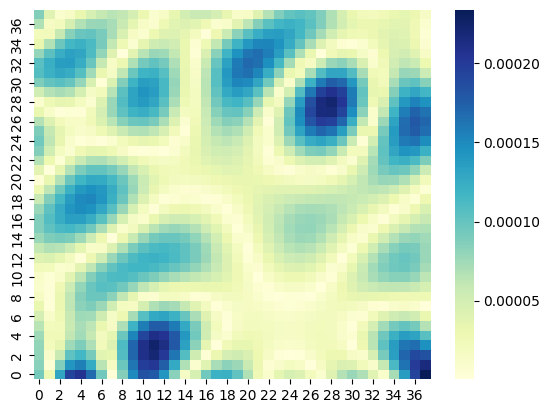

In [ ]:
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
if __name__ == '__main__':
    #set_seed(100)
    Nx = 1 # the number of sub-domains 
    Ny = 1
    M = 800 # the number of training parameters per sub-domain
    Qx = 19 # the number of collocation pointss per sub-domain 
    Qy = 19
    R_m=0.5
    time_start = time.time()  # 记录开始时间
    a = main(Nx,Ny,M,Qx,Qy,True)
    time_end = time.time()  # 记录结束时间
    print('程序运行时间：',time_end-time_start)

正问题的矩阵的条件数： 7.237651560109423e+17
矩阵的行列数: (1760,800)
********************* ERROR *********************
Nx=1,Ny=1,M=800,Qx=39,Qy=39
u_L_inf= 0.0002697097131640347 u_l_inf= 5.2487687322594084e-05 u_L_2= 0.00010079136840740428 u_l_2= 1.961481389647511e-05
边值条件误差
0.0001841353373297494 0.00019225402502431876 0.00021605390009593606 0.00020588666010201706
********************* ERROR *********************


C:\Users\78531\AppData\Local\Temp\ipykernel_92488\2987859532.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_o=math.sqrt(sum(u_t*u_t)/len(true_values.reshape((-1,1))))
C:\Users\78531\AppData\Local\Temp\ipykernel_92488\2987859532.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('u_L_inf=',e.max(),'u_l_inf=',e.max()/u_o,'u_L_2=',math.sqrt(sum(e*e)/len(e)),'u_l_2=',math.sqrt(sum(e*e)/len(e))/u_o)# *为矩阵逐元素乘法


程序运行时间： 10.646934032440186


C:\Users\78531\AppData\Local\Temp\ipykernel_92488\2987859532.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return(e.max(),math.sqrt(sum(e*e)/len(e)),h)


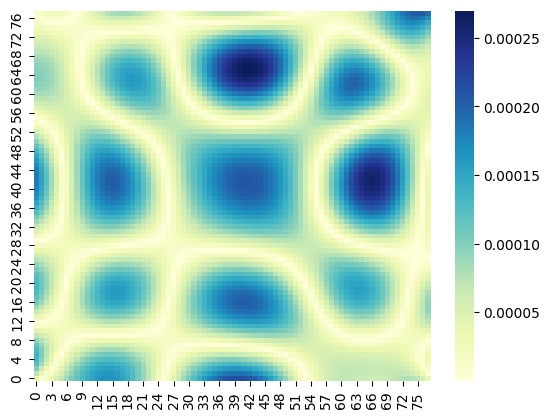

In [7]:
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
if __name__ == '__main__':
    #set_seed(100)
    Nx = 1 # the number of sub-domains 
    Ny = 1
    M = 800 # the number of training parameters per sub-domain
    Qx = 39 # the number of collocation pointss per sub-domain 
    Qy = 39
    R_m=0.5
    time_start = time.time()  # 记录开始时间
    a = main(Nx,Ny,M,Qx,Qy,True)
    time_end = time.time()  # 记录结束时间
    print('程序运行时间：',time_end-time_start)
    

In [ ]:
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
if __name__ == '__main__':
    #set_seed(100)
    Nx = 1 # the number of sub-domains 
    Ny = 1
    M = 1600 # the number of training parameters per sub-domain
    Qx = 39 # the number of collocation pointss per sub-domain 
    Qy = 39
    R_m=0.5
    time_start = time.time()  # 记录开始时间
    a = main(Nx,Ny,M,Qx,Qy,True)
    time_end = time.time()  # 记录结束时间
    print('程序运行时间：',time_end-time_start)
    

In [ ]:
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
if __name__ == '__main__':
    #set_seed(100)
    Nx = 2 # the number of sub-domains 
    Ny = 2
    M = 100 # the number of training parameters per sub-domain
    Qx = 9 # the number of collocation pointss per sub-domain 
    Qy = 9
    R_m=0.5
    time_start = time.time()  # 记录开始时间
    a = main(Nx,Ny,M,Qx,Qy,True)
    time_end = time.time()  # 记录结束时间
    print('程序运行时间：',time_end-time_start)

In [ ]:
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
if __name__ == '__main__':
    #set_seed(100)
    Nx = 2 # the number of sub-domains 
    Ny = 2
    M = 100 # the number of training parameters per sub-domain
    Qx = 19 # the number of collocation pointss per sub-domain 
    Qy = 19
    R_m=0.5
    time_start = time.time()  # 记录开始时间
    a = main(Nx,Ny,M,Qx,Qy,True)
    time_end = time.time()  # 记录结束时间
    print('程序运行时间：',time_end-time_start)

In [ ]:
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
if __name__ == '__main__':
    #set_seed(100)
    Nx = 2 # the number of sub-domains 
    Ny = 2
    M = 200 # the number of training parameters per sub-domain
    Qx = 9 # the number of collocation pointss per sub-domain 
    Qy = 9
    R_m=0.5
    time_start = time.time()  # 记录开始时间
    a = main(Nx,Ny,M,Qx,Qy,True)
    time_end = time.time()  # 记录结束时间
    print('程序运行时间：',time_end-time_start)

In [ ]:
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
if __name__ == '__main__':
    #set_seed(100)
    Nx = 2 # the number of sub-domains 
    Ny = 2
    M = 200 # the number of training parameters per sub-domain
    Qx = 19 # the number of collocation pointss per sub-domain 
    Qy = 19
    R_m=0.5
    time_start = time.time()  # 记录开始时间
    a = main(Nx,Ny,M,Qx,Qy,True)
    time_end = time.time()  # 记录结束时间
    print('程序运行时间：',time_end-time_start)

In [ ]:
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
if __name__ == '__main__':
    #set_seed(100)
    Nx = 2 # the number of sub-domains 
    Ny = 2
    M = 400 # the number of training parameters per sub-domain
    Qx = 19 # the number of collocation pointss per sub-domain 
    Qy = 19
    R_m=0.5
    time_start = time.time()  # 记录开始时间
    a = main(Nx,Ny,M,Qx,Qy,True)
    time_end = time.time()  # 记录结束时间
    print('程序运行时间：',time_end-time_start)

In [ ]:
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
if __name__ == '__main__':
    #set_seed(100)
    Nx = 2 # the number of sub-domains 
    Ny = 2
    M = 400 # the number of training parameters per sub-domain
    Qx = 39 # the number of collocation pointss per sub-domain 
    Qy = 39
    R_m=0.5
    time_start = time.time()  # 记录开始时间
    a = main(Nx,Ny,M,Qx,Qy,True)
    time_end = time.time()  # 记录结束时间
    print('程序运行时间：',time_end-time_start)